## Final Project Submission

Please fill out:
<b>
* Student name: William Newton
* Student pace: Full-Time
* Scheduled project review date/time: 06/04/2020
* Instructor name: Amber Yandow
* Blog post URL: <b/>


# Import Libraries #

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import cohen_kappa_score, roc_curve, auc, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

# Function Engineering #

In [2]:
def quick_hist(data,col):
    #plot quick histogram of relevant column
    plt.figure(figsize=(10,5))
    data[col].hist()

In [3]:
def make_heatmap(df,cols):
    # plot quick heatmap of correlation between different cols in a data set in order to check for multicollinearity
    plt.figure(figsize=(12,6))
    return sns.heatmap(df[cols].corr(),annot=True,cmap='coolwarm'),print(abs(df[cols].corr()>.75).sum())

In [151]:
def quick_model_eval(X_train, X_test, y_train, y_test, model=0):
    # Calculate the probability scores of each point in the training set
    y_train_score = model.predict(X_train)
    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
    # Calculate the probability scores of each point in the test set
    y_test_score = model.predict(X_test)
    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    plt.figure(figsize=(10, 8))
    lw = 2
    # Plot ROC curve for training set, test set, and 50/50 line
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Training and Test Set')
    plt.legend(loc='lower right')
    plt.show()
    # Print the area under the roc curve
    print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr),5)))
    print('Test AUC: {}'.format(round(auc(test_fpr, test_tpr),5)))
    print('\n\n')
    # Print confusion matrix
    print('Confusion Matrix')
    print('True 0s | False 1s')
    print('False 0s | True 1s')
    print(confusion_matrix(y_test, y_test_score))
    print('\n\n')
    # Print Classification Report
    print('Classification Report')
    print(classification_report(y_test, y_test_score))
    print('\n\n')
    # Print Train/Test Set Recall
    print('Training Recall: ', round(recall_score(y_train, y_train_score),4))
    print('Testing Recall: ', round(recall_score(y_test, y_test_score),4))
    print('\n\n')
    # Print Train/Test Set F_Beta Score
    print("Training F_Beta Score",round(fbeta_score(y_train, y_train_score, beta=2.0),4))
    print("Testing F_Beta Score",round(fbeta_score(y_test, y_test_score, beta=2.0),4)) 
    # Print Train/Test Set Cohen's Kappa
    print("Training Cohen's Kappa", round(cohen_kappa_score(y_train, y_train_score),4))
    print("Testing Cohen's Kappa", round(cohen_kappa_score(y_test, y_test_score), 4))
    print('\n\n')
    # Print Train/Test Set Precision
    print('Training Precision: ', round(precision_score(y_train, y_train_score),4))
    print('Testing Precision: ', round(precision_score(y_test, y_test_score),4))
    print('\n\n')
    # Print Train/Test Set Accuracy
    print('Training Accuracy: ', round(accuracy_score(y_train, y_train_score),4))
    print('Testing Accuracy: ', round(accuracy_score(y_test, y_test_score),4))
    print('\n\n')
    # Print Train/Test Set F1-Score
    print('Training F1-Score: ', round(f1_score(y_train, y_train_score),4))
    print('Testing F1-Score: ', round(f1_score(y_test, y_test_score),4))
    print('\n\n')

In [5]:
def quick_bar(col):
    # quickly plot bar graphs that show total number of cases present in data set related to categorical columns
    # and the amount of those instances that churned in red
    df_col = df.groupby(col).sum()
    df_col1 = df.groupby(col).count()
    fig, ax = plt.subplots(figsize=(10,5))
    ax1 = sns.barplot(data = df_col1, x=df_col1.index, y='SeniorCitizen', color='blue', label='Total Cases')
    ax2 = sns.barplot(data=df_col, x=df_col.index, y='Churn', color='red', label='Total Churned')
    plt.title(col, size=15)
    plt.legend()
    plt.show()

In [6]:
def plot_feature_importance(model):
    # quickly plot the feature importance of features used in the model to be compared against each other
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


# Import Data Set and Pre-Processing

<b>Loaded Data Set into Jupyter Notebook and began by checking column data types<b/>

In [7]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [10]:
df.sort_values('TotalCharges')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6646,8249-THVEC,Male,0,Yes,Yes,51,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.40,997.75,No
5598,6051-PTVNS,Female,0,Yes,Yes,55,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.15,998.1,No
3686,5899-MQZZL,Female,0,No,No,13,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,75.00,999.45,Yes
3353,4536-PLEQY,Male,0,Yes,No,12,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Credit card (automatic),85.05,999.8,No


In [11]:
len(df.loc[df['TotalCharges'] == ' '])

11

<b>Identified 11 rows with missing Total Charges. Deleted from data frame and changed row type to float<b/>

In [12]:
df=df.loc[df['TotalCharges'] != ' ']
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df['TotalCharges']=df['TotalCharges'].astype('float')

<b>Changed SeniorCitizen column to string and changed binary codes to Yes/No for dummies later. 

All columns are correct data type now 

Dropped customerID column from data frame as it is not a predictive column<b/>

In [14]:
df['SeniorCitizen']=df['SeniorCitizen'].astype('str')

In [15]:
df['SeniorCitizen']=df['SeniorCitizen'].replace({'0': 'No', '1':'Yes'})

In [16]:
df['Churn']=df['Churn'].replace({'No': '0', 'Yes':'1'}).astype('int')

In [17]:
df=df.drop(columns='customerID', axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null int64
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


# EDA #

<b>Split out numerical and categorical data for further investigation.<b/>

In [19]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [20]:
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical = ['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

<b>
Plotted histograms of numerical columns to examine distributions. Numerical columns are not normally distributed
    
<b/>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffd0a1b8400>,
      dtype=object)

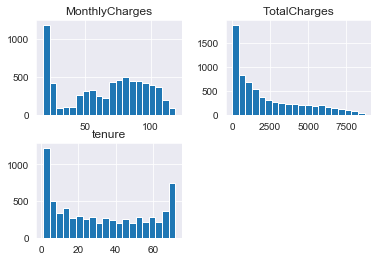

In [21]:
df[numerical].hist(bins=20)

<b>Plotted box plots of numerical columns. No major outliers are detected except in the Total Charges column, which is to be expected when compared to tenure and Monthly Charges as they are on a much smaller scale. Standardizing will be necessary to make sure that the Total Charges column influence on the model will be regulated
    <b/>

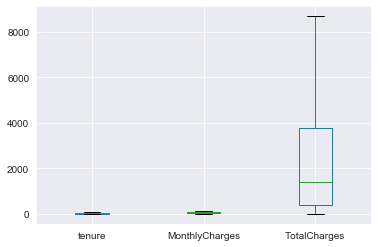

In [22]:
df[numerical].plot(kind='box')

<b>Plotted histograms of numerical columns again with churn class plotted on same visualization. Will clean this up and use in non-technical presentation as it will probably be a good explainer for what are the biggest causes of churn
    
From what I can see initially, tenure and Total Charges should be good predictors for churn as the cases of churn spike at extreme ends of their distributions
<b/>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffd0aaf48d0>,
      dtype=object)

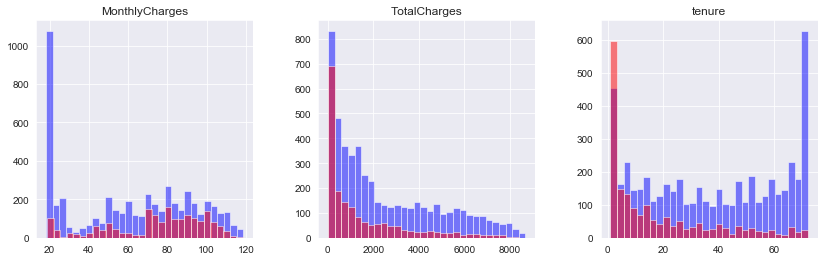

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == 0][numerical].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == 1][numerical].hist(bins=30, color="red", alpha=0.5, ax=ax)

<b>Wrote function to quickly plot bar graphs for categorical features in the data frame. Blue represents total cases in data frame and red represents the amount of those cases that churned
    
Gender column does not appear to have any great significance in predictive ability on Churn as the Churn cases for Male and Female are virtually identical. This column will most likely be dropped during feature selection
<b/>

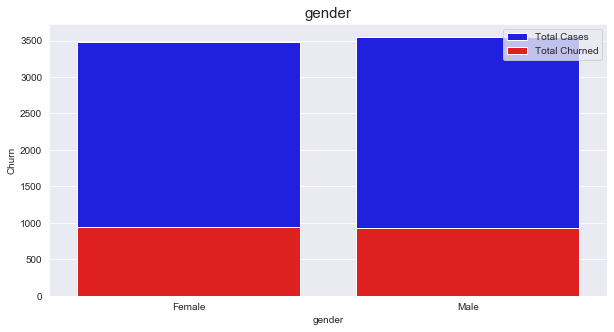

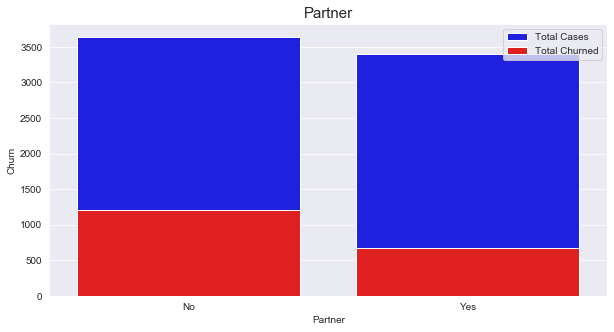

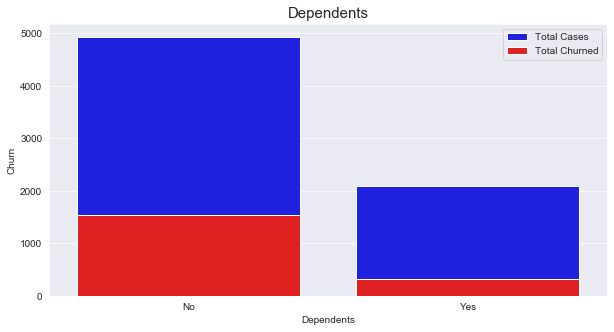

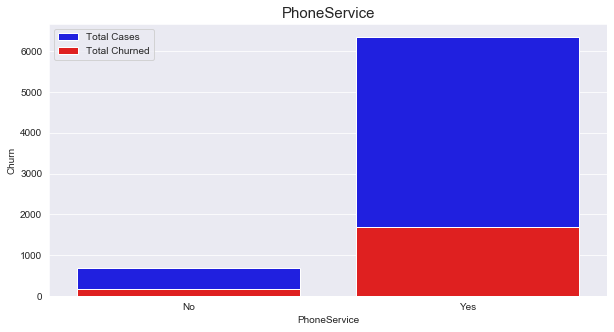

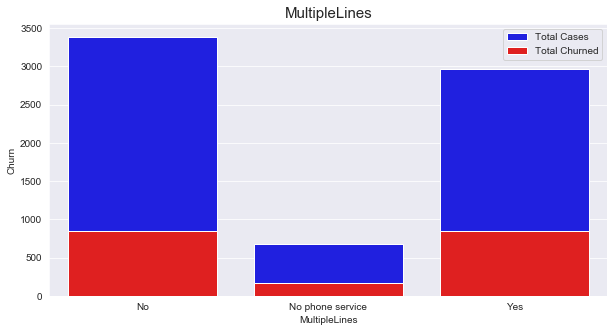

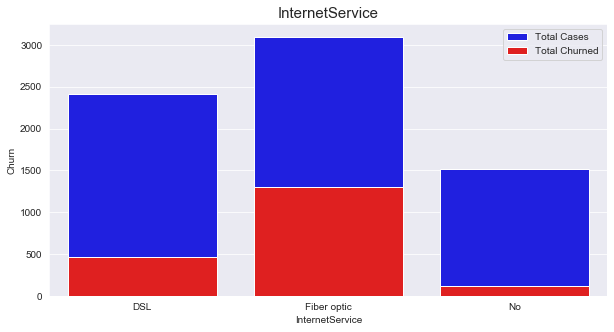

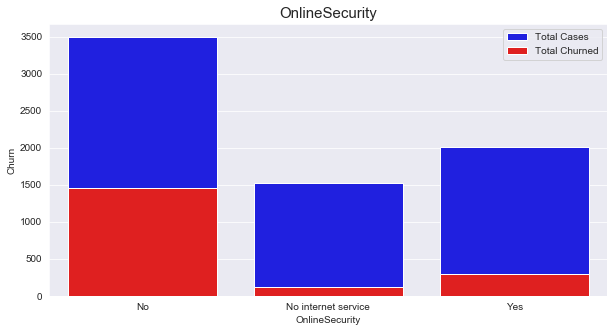

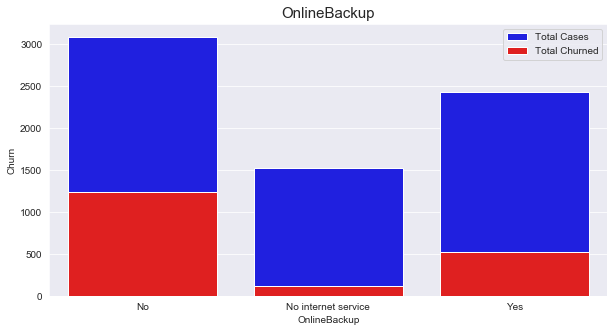

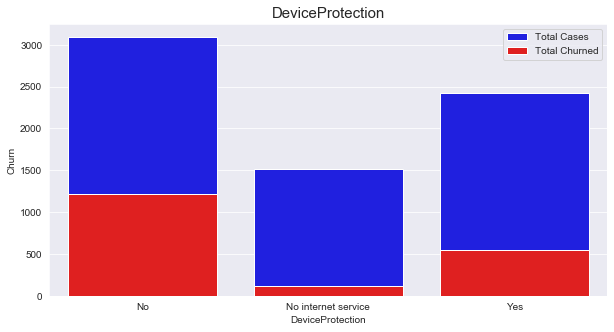

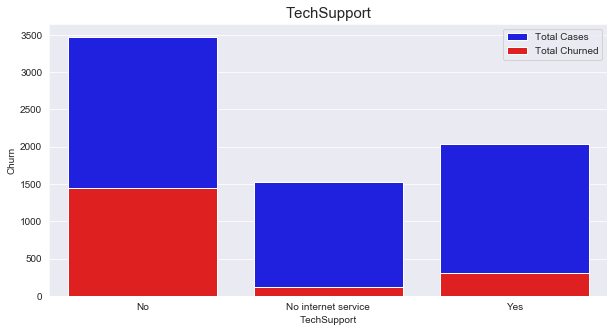

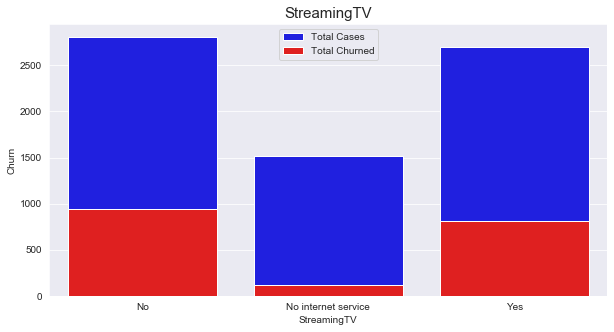

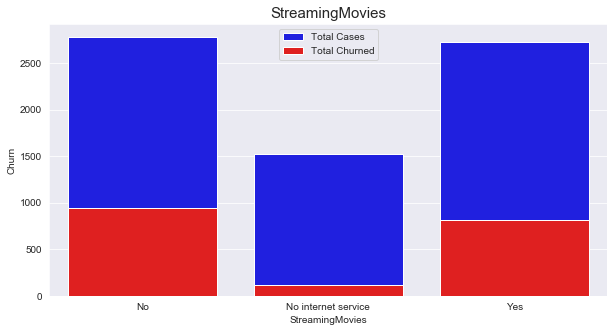

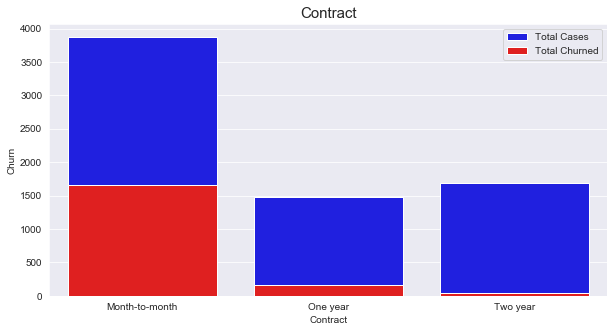

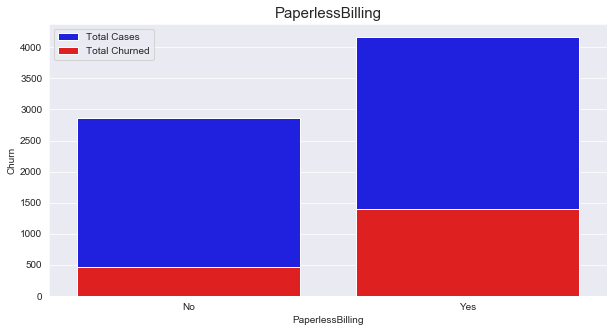

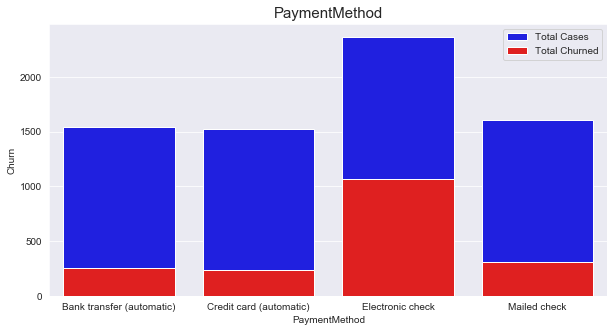

In [24]:
for col in categorical:
    quick_bar(col)

<b>Made heatmap of the numerical columns to check for multicollinearity. Strong multicollinearity detected in Total Charges and tenure columns. Will make a note to deal with this later by dropping one of these columns should this become an issue later<b/>

tenure            2
MonthlyCharges    1
TotalCharges      2
dtype: int64


(<matplotlib.axes._subplots.AxesSubplot at 0x7ffd0aaa24a8>, None)

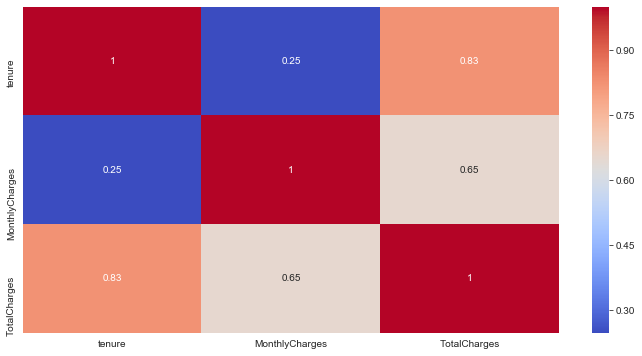

In [26]:
make_heatmap(df, numerical)

<b>
Plotted bar graph to analyze class distribution. 

Churn has occurred in 26.57% of cases in this data set, and not occurred in 73.42% of cases. 

Synthetic samples or class weights will be necessary in order to address the class imbalance.

<b/>

Percentage of Churn Class in Data Set is 26.58


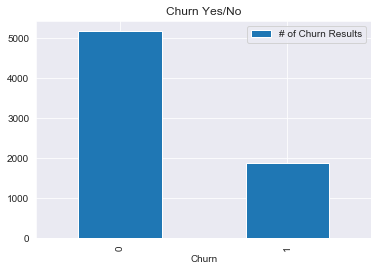

In [27]:
df.groupby('Churn').count().plot(kind='bar', y='gender', label='# of Churn Results')
plt.title('Churn Yes/No')
print('Percentage of Churn Class in Data Set is {}'.format(round(len(df.loc[df['Churn'] == 1])/len(df) * 100, 2)))

# Modeling Preprocessing #

<b>Split data set into predictor and target data frames to use for modeling shortly<b/>

In [29]:
y = df['Churn']
X = df.drop(columns = 'Churn', axis=1)

In [30]:
X[categorical]

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check
7039,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
7040,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
7041,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


<b>
Used pd.get_dummies on categorical columns since ML Models cannot use string columns for predictor variables. 
Dropped first column of dummy data for every original feature to reduce bias in the model
<b/>

In [31]:
X=pd.get_dummies(X, drop_first = True)

In [32]:
X.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


<b>
Standardized all features in data frame with MinMaxScaler to put all features on the same scale (bewteen 0 and 1) ensure that numerical features don't impact the model more than the others for the baseline model
<b/>

In [33]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.000000,0.115423,0.001275,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.464789,0.385075,0.215867,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.014085,0.354229,0.010310,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.619718,0.239303,0.210241,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.014085,0.521891,0.015330,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# Feature Engineering Before Fitting First Model

<b> 
Created Contract_Yes Column that combines the two Contract columns to reduce variance in the model
<b/>

In [34]:
X_feature_selected = X_scaled
X_feature_selected['Contract_Yes'] = X_feature_selected['Contract_One year'] + X_feature_selected['Contract_Two year']
X_feature_selected.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Yes
0,0.000000,0.115423,0.001275,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.464789,0.385075,0.215867,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.014085,0.354229,0.010310,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.619718,0.239303,0.210241,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.014085,0.521891,0.015330,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


<b>
Combined StreamingTV and StreamingMovies columns into one StreamingContent column to reduce variance. Also dropped contradictory columns that existed in the data set to avoid confusion. Not sure how someone could have MultipleLines but No Phone Service or StreamingTv but not Internet Service. Model is better served by removing these columns
<b/>

In [35]:
columns_to_drop = ['Contract_One year','Contract_Two year','StreamingTV_Yes','StreamingMovies_Yes',
                  'MultipleLines_No phone service','OnlineSecurity_No internet service','OnlineBackup_No internet service',
                  'StreamingTV_No internet service','StreamingMovies_No internet service']
X_feature_selected['StreamingContent_Yes'] = X_feature_selected['StreamingTV_Yes'] + X_feature_selected['StreamingMovies_Yes']
X_feature_selected['StreamingContent_Yes']=X_feature_selected['StreamingContent_Yes'].replace(to_replace = 2.0,value=1.0)
X_feature_selected.drop(columns = columns_to_drop,inplace=True)
X_feature_selected.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Yes,StreamingContent_Yes
0,0.000000,0.115423,0.001275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.464789,0.385075,0.215867,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.014085,0.354229,0.010310,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.619718,0.239303,0.210241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.014085,0.521891,0.015330,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


<b>Performed train/test split on Scaled selected features and target to use in modeling</b>

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_feature_selected, y, test_size = 0.25, random_state=42)

# SMOTE and Under/Over Sampling

<b>Performed SMOTE on original data set in order to see what the effect will be on the model results. Will also pass balanced class weights through model parameters to see what the effect will be for there as well. <b/>

In [37]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_SMOTE, y_train_SMOTE = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_SMOTE).value_counts()) 

Original class distribution: 

0    5163
1    1869
Name: Churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
dtype: int64


# Created Empty Data Frame to Keep Track of Model Results

In [40]:
model_results = pd.DataFrame()
model_results

""


# Logistic Regression

<b>Ran vanilla logistic regression model. Looking to maximize recall score because for this business case False Negatives are a bigger problem than Precision of the model<b/>

In [41]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

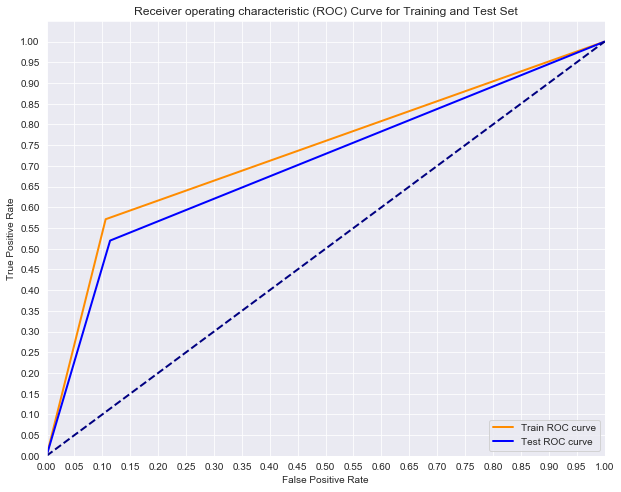

Training AUC: 0.73267
Test AUC: 0.7029



Confusion Matrix
TP | FN
FP | TN
[[1152  148]
 [ 220  238]]



Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1300
           1       0.62      0.52      0.56       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758




Training Recall:  0.5712
Testing Recall:  0.5197



Training F_Beta Score 0.5875
Testing F_Beta Score 0.5365
Training Cohen's Kappa 0.4868
Testing Cohen's Kappa 0.4276



Training Precision:  0.6634
Testing Precision:  0.6166



Training Accuracy:  0.8077
Testing Accuracy:  0.7907



Training F1-Score:  0.6139
Testing F1-Score:  0.564





In [42]:
quick_model_eval(X_train, X_test, y_train, y_test, model=logreg)

<b>Appended model results to Model Results DF. Vanilla model performed poorly when attempting to predict 1's in Churn column<b/>

In [43]:
column_names = ['Model #', 'Model Type', 'Train AUC', 'Test AUC', 'Train Recall', 'Test Recall', 'Recall 0',
               'Recall 1', 'Train F_Beta Score','Test F_Beta Score','Train Cohens Kappa','Test Cohens Kappa','Notes']
results = [1, 'Vanilla Log Reg',73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,'Baseline performs poorly when attempting to predict 1s']

In [44]:
results_dict = dict(zip(column_names,results))
model_results=pd.DataFrame(results_dict, index = range(1))
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...


<b>Fit new model with SMOTE data to see difference in predictive ability of Churn 1's<b/>

In [45]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
logreg.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

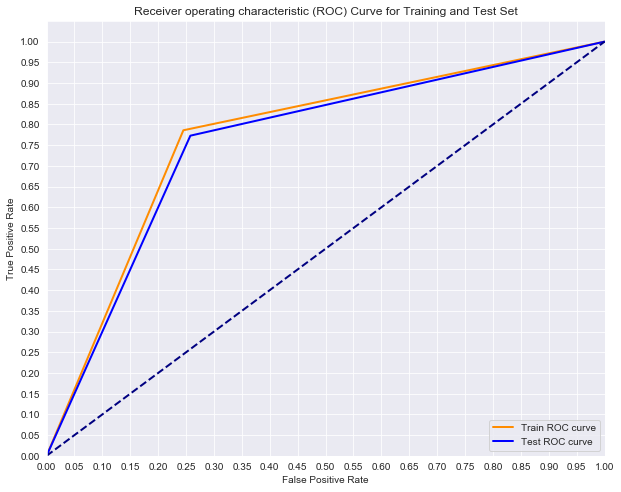

Training AUC: 0.77041
Test AUC: 0.75762



Confusion Matrix
TP | FN
FP | TN
[[965 335]
 [104 354]]



Classification Report
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1300
           1       0.51      0.77      0.62       458

    accuracy                           0.75      1758
   macro avg       0.71      0.76      0.72      1758
weighted avg       0.80      0.75      0.76      1758




Training Recall:  0.786
Testing Recall:  0.7729



Training F_Beta Score 0.7201
Testing F_Beta Score 0.7021
Training Cohen's Kappa 0.4723
Testing Cohen's Kappa 0.4429



Training Precision:  0.5394
Testing Precision:  0.5138



Training Accuracy:  0.7632
Testing Accuracy:  0.7503



Training F1-Score:  0.6397
Testing F1-Score:  0.6173





In [46]:
quick_model_eval(X_train, X_test, y_train, y_test, model=logreg)

In [47]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes']

<b>Model performed significantly better at predicting Churn 1's. Will next pass class_weight value of balanced to compare results<b/>

In [48]:
results = [2, 'SMOTE Log Reg', 76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5, 'Model performed better, additional tuning needed']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [49]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed"


<b>Passed class_weight value of balanced to deal with class imbalance problems</b>

In [50]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear',class_weight='balanced')
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

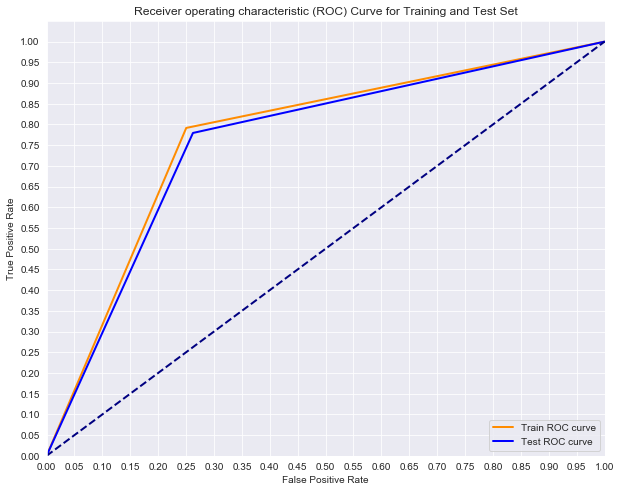

Training AUC: 0.77066
Test AUC: 0.75858



Confusion Matrix
TP | FN
FP | TN
[[959 341]
 [101 357]]



Classification Report
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1300
           1       0.51      0.78      0.62       458

    accuracy                           0.75      1758
   macro avg       0.71      0.76      0.72      1758
weighted avg       0.80      0.75      0.76      1758




Training Recall:  0.7916
Testing Recall:  0.7795



Training F_Beta Score 0.7227
Testing F_Beta Score 0.7055
Training Cohen's Kappa 0.4701
Testing Cohen's Kappa 0.4421



Training Precision:  0.536
Testing Precision:  0.5115



Training Accuracy:  0.7609
Testing Accuracy:  0.7486



Training F1-Score:  0.6392
Testing F1-Score:  0.6176





In [51]:
quick_model_eval(X_train, X_test, y_train, y_test, model=logreg)

<b>Model performed slightly better buy passing class_weight value of balance increased overfit a little. Will need to continue to monitor overfit and feature select as modeling continues<b/>

In [52]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes']

In [53]:
results = [3, 'Class Weight Balanced Log Reg', 77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2, 'Balanced class weights results in slightly better model']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [54]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed"
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...


# Feature Selection for Logistic Regression Model

<b>Used model coefficients to plot importances and effectiveness within Logistic Regression model of individual features. Will remove less predictive features to see how it effects the model<b/>

In [55]:
logreg_coef=pd.DataFrame(logreg.coef_, columns = list(X_feature_selected.columns))
logreg_coef

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Yes,StreamingContent_Yes
0,-3.345092,5.538015,1.417421,0.035871,0.298398,0.128103,-0.236276,-1.284169,-0.142948,-0.523384,0.202348,-0.638789,-0.328036,0.202348,-0.25713,0.202348,-0.616881,0.293915,0.093744,0.483136,0.130813,-0.997722,-0.443428


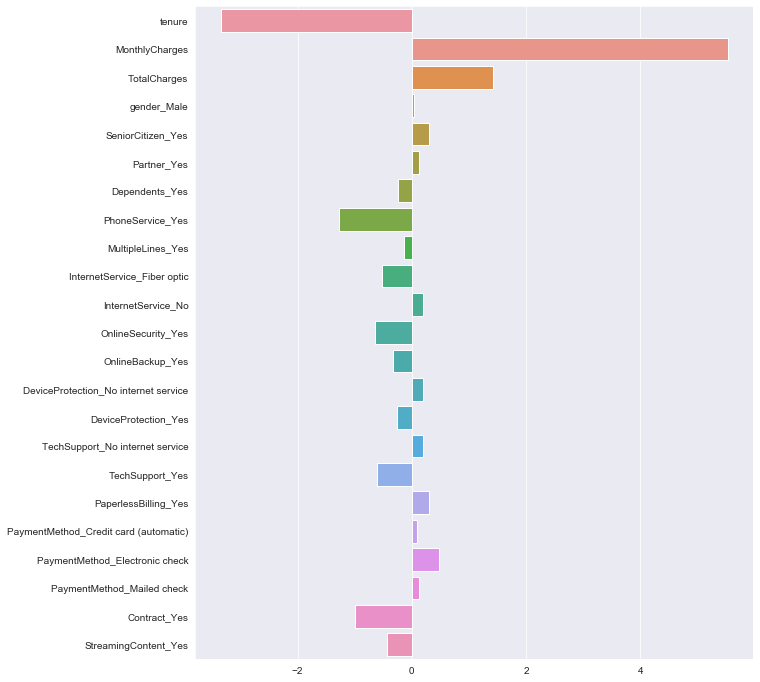

In [153]:
plt.figure(figsize=(10,12))
sns.barplot(data=logreg_coef, orient='h')

<b>Removed less predictive columns to reduce variance and improve model performance and reduce overfit

In [57]:
X_logreg_feature_selects=X_feature_selected[['tenure','MonthlyCharges','TotalCharges','PhoneService_Yes','InternetService_Fiber optic','OnlineSecurity_Yes','TechSupport_Yes',
         'PaymentMethod_Electronic check','Contract_Yes','StreamingContent_Yes']]
X_logreg_feature_selects.head()

,tenure,MonthlyCharges,TotalCharges,PhoneService_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,TechSupport_Yes,PaymentMethod_Electronic check,Contract_Yes,StreamingContent_Yes
0,0.000000,0.115423,0.001275,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.464789,0.385075,0.215867,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.014085,0.354229,0.010310,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.619718,0.239303,0.210241,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.014085,0.521891,0.015330,1.0,1.0,0.0,0.0,1.0,0.0,0.0


<b>Re-ran train_test_split after feature selection<b/>

In [58]:
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_logreg_feature_selects, y, test_size=0.25,random_state=42)

# Re-Run Logistic Regression Model After Feature Selection

In [59]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear',class_weight='balanced')
logreg.fit(X_train_logreg, y_train_logreg)

LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

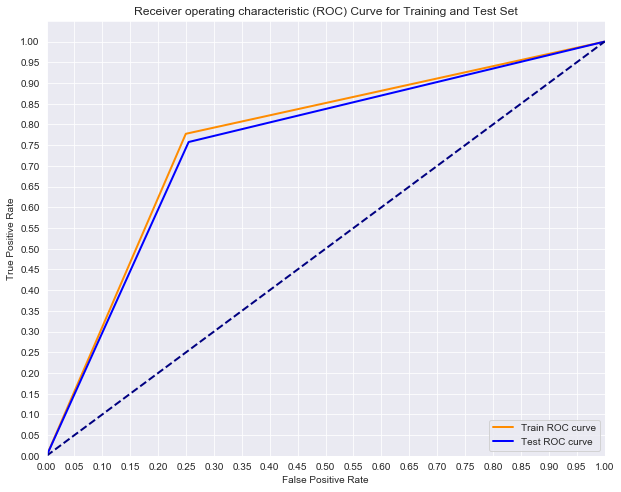

Training AUC: 0.76396
Test AUC: 0.75151



Confusion Matrix
TP | FN
FP | TN
[[969 331]
 [111 347]]



Classification Report
              precision    recall  f1-score   support

           0       0.90      0.75      0.81      1300
           1       0.51      0.76      0.61       458

    accuracy                           0.75      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.80      0.75      0.76      1758




Training Recall:  0.7775
Testing Recall:  0.7576



Training F_Beta Score 0.7119
Testing F_Beta Score 0.6912
Training Cohen's Kappa 0.4606
Testing Cohen's Kappa 0.4353



Training Precision:  0.5323
Testing Precision:  0.5118



Training Accuracy:  0.7577
Testing Accuracy:  0.7486



Training F1-Score:  0.6319
Testing F1-Score:  0.6109





In [60]:
quick_model_eval(X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg, model=logreg)

<b>Model performed slightly worse after feature selection. Removing predictive features did not make a better model and should only be used when overfitting is a problem<b/>

In [61]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed"
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...


In [62]:
results = [4, 'CWB Log Reg w/ Feature Selection', 76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5, 'Slightly worse model, moving on to different model']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

# Random Forest Classification Model

<b>Moving on to Random Forest Models. This ensemble models should help create better models overall. <b/>

In [63]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

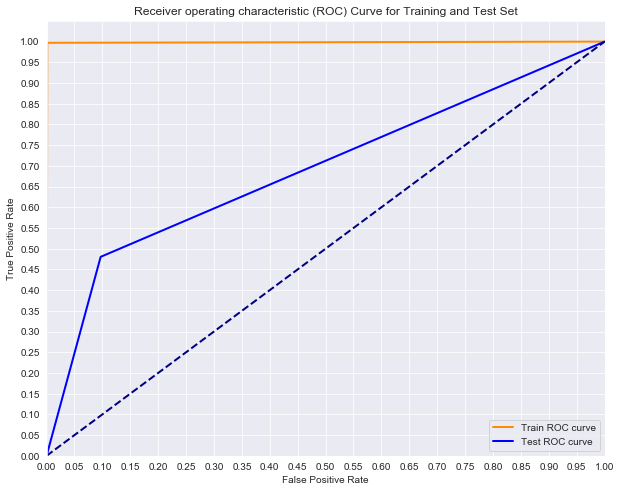

Training AUC: 0.99794
Test AUC: 0.69171



Confusion Matrix
TP | FN
FP | TN
[[1174  126]
 [ 238  220]]



Classification Report
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1300
           1       0.64      0.48      0.55       458

    accuracy                           0.79      1758
   macro avg       0.73      0.69      0.71      1758
weighted avg       0.78      0.79      0.78      1758




Training Recall:  0.9972
Testing Recall:  0.4803



Training F_Beta Score 0.997
Testing F_Beta Score 0.5051
Training Cohen's Kappa 0.9956
Testing Cohen's Kappa 0.4164



Training Precision:  0.9965
Testing Precision:  0.6358



Training Accuracy:  0.9983
Testing Accuracy:  0.7929



Training F1-Score:  0.9968
Testing F1-Score:  0.5473





In [64]:
quick_model_eval(X_train, X_test, y_train, y_test,model=forest)

<b>
    
Vanilla RFC shows massive overfitting which makes sense since Decision Trees are greedy learners and will exhaust all possibilities for fit unless you tune the hyperparameters. Will GridSearch next to determine ideal hyperparameter values
    
<b/>

In [65]:
results = [5, 'Vanilla Random Forest', 99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0, 'Significant Overfitting']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [66]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed"
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m..."
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting


<b>Perform GridSearch to select best hyperparameters for RFC model. <b/>

In [67]:
forest = RandomForestClassifier()
param_grid = {
    'criterion' : ['gini','entropy'],
    'n_estimators' : [100, 150, 200, 250, 300],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10],
    'min_samples_split' : [2, 5, 10, 15],
    'min_samples_leaf' : [1, 2, 5, 10] 
}
forest = GridSearchCV(forest, param_grid, cv=3, n_jobs=-1)
forest.fit(X_train, y_train)

forest.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 250}

<b>Input best_params as hyperparameters for next RFC model<b/>

In [68]:
forest = RandomForestClassifier(n_estimators=250, criterion='entropy', random_state=42, min_samples_leaf = 5, min_samples_split = 15, max_depth = 8, class_weight='balanced')
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=15, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

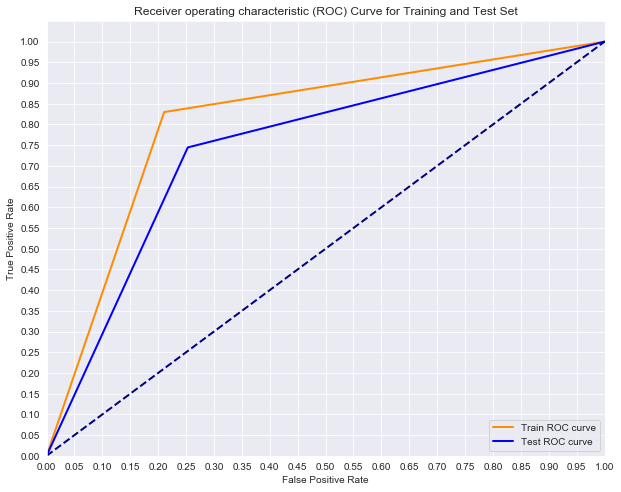

Training AUC: 0.8096
Test AUC: 0.74573



Confusion Matrix
TP | FN
FP | TN
[[971 329]
 [117 341]]



Classification Report
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1300
           1       0.51      0.74      0.60       458

    accuracy                           0.75      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.79      0.75      0.76      1758




Training Recall:  0.8299
Testing Recall:  0.7445



Training F_Beta Score 0.7675
Testing F_Beta Score 0.6815
Training Cohen's Kappa 0.5484
Testing Cohen's Kappa 0.4274



Training Precision:  0.5899
Testing Precision:  0.509



Training Accuracy:  0.8002
Testing Accuracy:  0.7463



Training F1-Score:  0.6896
Testing F1-Score:  0.6046





In [69]:
quick_model_eval(X_train, X_test, y_train, y_test,model=forest)

<b>Overfitting still occuring in model but is greatly reduced. Will perform feature selection to see if that helps the model <b>

In [70]:
results = [6, 'Random Forest Classifier after GridSearch', 80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7, 'Overfitting After GridSearch']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

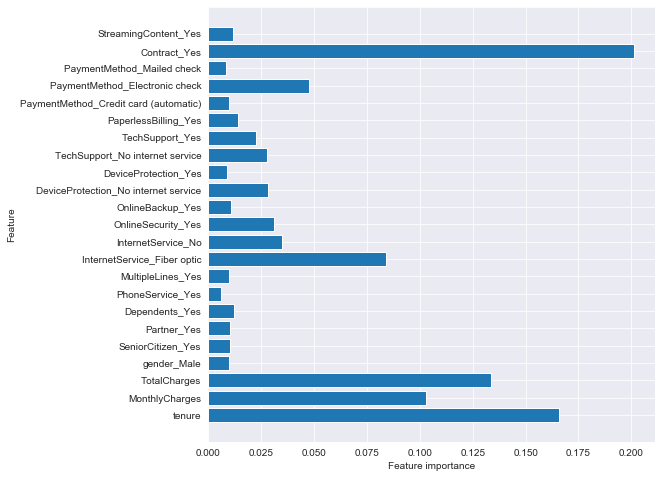

In [71]:
plot_feature_importance(forest)

<b> Most important coefficients are Tenure, Contract, Internet Service Fiber Optic, Total Charges, Monthly Charges

<b>Removed less predictive variables from model to help with overfitting <b/>

In [72]:
X_forest_feature_selects = X_feature_selected[['Contract_Yes','PaymentMethod_Electronic check','TechSupport_Yes','TechSupport_No internet service','DeviceProtection_No internet service',
                                              'OnlineSecurity_Yes','InternetService_No','InternetService_Fiber optic','TotalCharges','MonthlyCharges','tenure']]

In [73]:
X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_forest_feature_selects, y, test_size=0.25, random_state=42)

In [74]:
forest = RandomForestClassifier(n_estimators=250, criterion='entropy', random_state=42, min_samples_leaf = 5, min_samples_split = 15, max_depth = 8, class_weight='balanced')
forest.fit(X_train_forest,y_train_forest)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=15, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

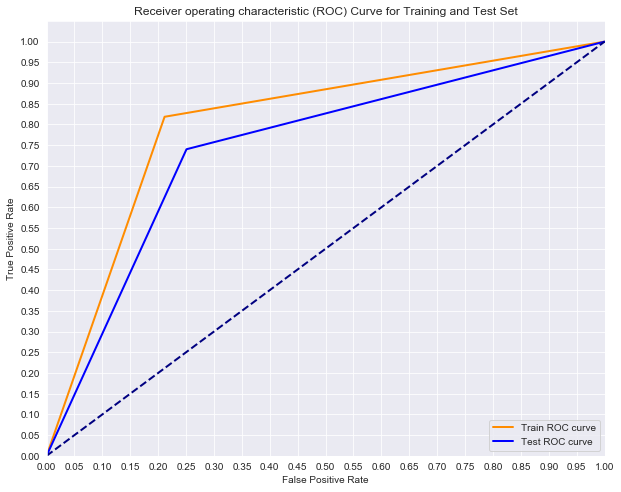

Training AUC: 0.80354
Test AUC: 0.7447



Confusion Matrix
TP | FN
FP | TN
[[974 326]
 [119 339]]



Classification Report
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1300
           1       0.51      0.74      0.60       458

    accuracy                           0.75      1758
   macro avg       0.70      0.74      0.71      1758
weighted avg       0.79      0.75      0.76      1758




Training Recall:  0.8186
Testing Recall:  0.7402



Training F_Beta Score 0.7583
Testing F_Beta Score 0.6788
Training Cohen's Kappa 0.5391
Testing Cohen's Kappa 0.4269



Training Precision:  0.5857
Testing Precision:  0.5098



Training Accuracy:  0.7965
Testing Accuracy:  0.7469



Training F1-Score:  0.6828
Testing F1-Score:  0.6037





In [75]:
quick_model_eval(X_train_forest, X_test_forest, y_train_forest, y_test_forest,model=forest)

<b>Overfitting still an issue even after feature selection. Will run an additional GridSearch with max_features included to address concerns. Forgot to include that parameter in the last GrdiSearch <b/>

In [76]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes']

In [77]:
results = [7, 'RFC after Feature Selection', 80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6, 'Overfitting After Feature Selection']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [78]:
model_results['Train_Test_Difference'] = abs(model_results['Train AUC'] - model_results['Test AUC'])
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes,Train_Test_Difference
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...,3.0
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed",0.5
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...,1.2
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m...",1.2
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting,31.7
0,6,Random Forest Classifier after GridSearch,80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7,Overfitting After GridSearch,6.4
0,7,RFC after Feature Selection,80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6,Overfitting After Feature Selection,5.9


<b>Ran additional GridSearch with max features included<b/>

In [79]:
forest = RandomForestClassifier()
param_grid = {
    'max_features' : ['auto','log2'],
    'criterion' : ['gini','entropy'],
    'n_estimators' : [100, 150, 200, 250, 300],
    'max_depth' : [5,6,7,8,9,10],
    'min_samples_split' : [2, 5, 10, 15],
    'min_samples_leaf' : [1, 2, 5, 10] 
}
forest = GridSearchCV(forest, param_grid, cv=3, n_jobs=-1)
forest.fit(X_train_forest, y_train_forest)

forest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 100}

<b>Included new hyperparameter values in new model. Overfitting was still occuring by 1 or 2 percentage points. Manually reduced max_depth from 8 to 5 to get overfitting to acceptable level

In [94]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf = 10, min_samples_split = 15, max_depth = 5, class_weight='balanced', max_features='log2')
forest.fit(X_train_forest,y_train_forest)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=15, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

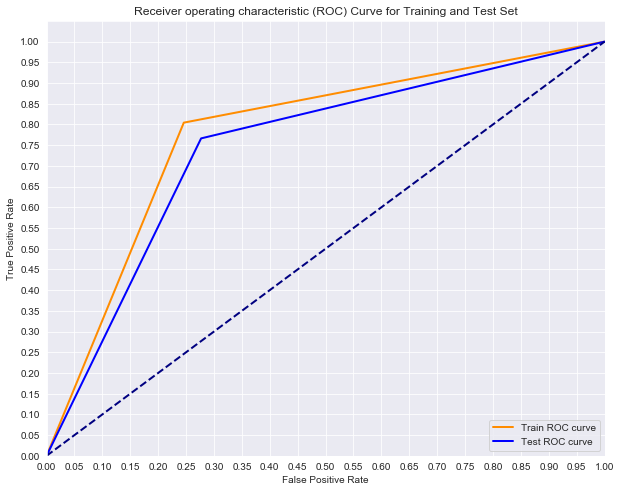

Training AUC: 0.77924
Test AUC: 0.74473



Confusion Matrix
TP | FN
FP | TN
[[940 360]
 [107 351]]



Classification Report
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1300
           1       0.49      0.77      0.60       458

    accuracy                           0.73      1758
   macro avg       0.70      0.74      0.70      1758
weighted avg       0.79      0.73      0.75      1758




Training Recall:  0.8044
Testing Recall:  0.7664



Training F_Beta Score 0.7342
Testing F_Beta Score 0.6901
Training Cohen's Kappa 0.485
Testing Cohen's Kappa 0.4152



Training Precision:  0.5444
Testing Precision:  0.4937



Training Accuracy:  0.7675
Testing Accuracy:  0.7344



Training F1-Score:  0.6493
Testing F1-Score:  0.6005





In [96]:
quick_model_eval(X_train_forest, X_test_forest, y_train_forest, y_test_forest,model=forest)

<b>Final RFC model no longer has significant overfitting issues thanks to feature selection and max_features GridSearch

In [88]:
column_names.append('Train_Test_Difference')

In [89]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [90]:
results = [8, 'RFC after GridSearch w/ Max Features', 77.9,75.3,81.1,79.2,72.0,79.0,73.7,70.7,48.2,42.5, ' ',2.6]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [91]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes,Train_Test_Difference
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...,3.0
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed",0.5
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...,1.2
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m...",1.2
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting,31.7
0,6,Random Forest Classifier after GridSearch,80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7,Overfitting After GridSearch,6.4
0,7,RFC after Feature Selection,80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6,Overfitting After Feature Selection,5.9
0,8,RFC after GridSearch w/ Max Features,77.9,75.3,81.1,79.2,72.0,79.0,73.7,70.7,48.2,42.5,,2.6


<b>Random Forest Model has been tuned appropriately. My intuition tells me that Random Forest Classifiers are the best model for this classification task but I would like to experiment with Support Vector Machines to see the difference

In [227]:
forest_df=pd.DataFrame(list(forest.feature_importances_),index=list(X_forest_feature_selects.columns))
forest_df=forest_df.transpose()

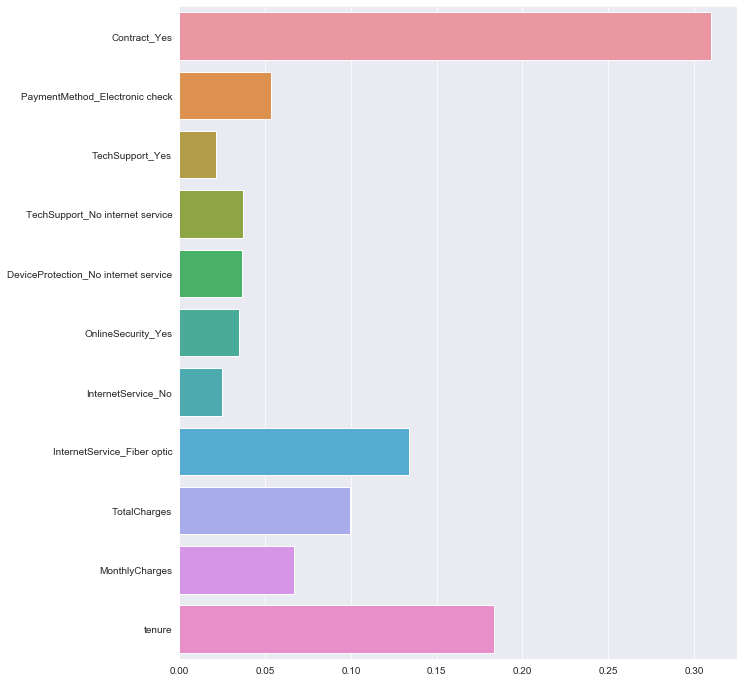

In [228]:
plt.figure(figsize=(10,12))
sns.barplot(data=forest_df, orient='h')

<b>Most important coefficients are Contract, Tenure, Internet Service_Fiber optic

# Support Vector Machine

<b>Next model to try is Support Vector Machines with Linear kernel. Will continue to pass class_weight value of balanced as that has proven to be the best way to tune the model to predict Churn 1's. Using Linear kernel because they are supposed to be best for predicting binary classification problems

In [103]:
svm_clf = SVC(kernel='linear',class_weight='balanced' )
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

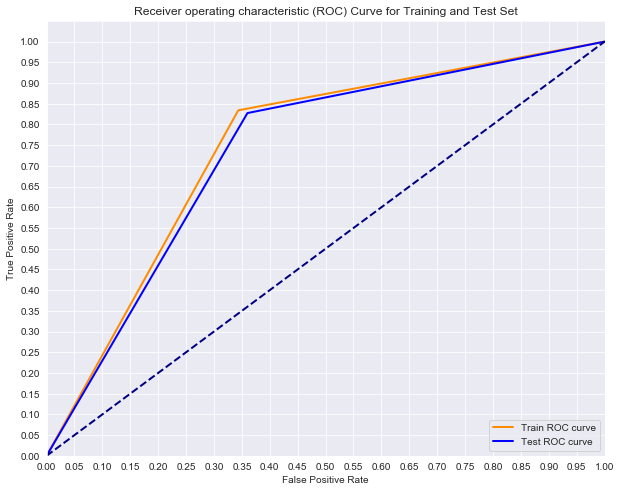

Training AUC: 0.74532
Test AUC: 0.73376



Confusion Matrix
TP | FN
FP | TN
[[832 468]
 [ 79 379]]



Classification Report
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1300
           1       0.45      0.83      0.58       458

    accuracy                           0.69      1758
   macro avg       0.68      0.73      0.67      1758
weighted avg       0.79      0.69      0.71      1758




Training Recall:  0.8342
Testing Recall:  0.8275



Training F_Beta Score 0.7223
Testing F_Beta Score 0.7074
Training Cohen's Kappa 0.3938
Testing Cohen's Kappa 0.3667



Training Precision:  0.47
Testing Precision:  0.4475



Training Accuracy:  0.704
Testing Accuracy:  0.6889



Training F1-Score:  0.6013
Testing F1-Score:  0.5808





In [104]:
quick_model_eval(X_train, X_test, y_train, y_test,model=svm_clf)

<b>Highest recall score out of all the models but there are significantly more False Negatives in the test set predictions

In [106]:
results = [9, 'Vanilla Linear SVM', 74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6, 'Highest Recall Score',1.2]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [107]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes,Train_Test_Difference
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...,3.0
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed",0.5
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...,1.2
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m...",1.2
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting,31.7
0,6,Random Forest Classifier after GridSearch,80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7,Overfitting After GridSearch,6.4
0,7,RFC after Feature Selection,80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6,Overfitting After Feature Selection,5.9
0,8,RFC after GridSearch w/ Max Features,77.9,75.3,81.1,79.2,72.0,79.0,73.7,70.7,48.2,42.5,,2.6
0,9,Vanilla Linear SVM,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,Highest Recall Score,1.2


<b>Ran GridSearch to determine best values for C and gamma for SVM
    
    
C is a regularization parameter that controls the trade off between the achieving a low training error and a low testing error that is the ability to generalize your classifier to unseen data.

Gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

In [113]:
svm_clf = SVC(kernel='linear', class_weight='balanced')
param_grid = {
     'C':[0.1,1,10,100,1000],
    'gamma':[1,0.1,0.01,0.001,0.0001]

}
gs_svm = GridSearchCV(svm_clf, param_grid, cv=3, n_jobs=-1)
gs_svm.fit(X_train, y_train)

gs_svm.best_params_

{'C': 1000, 'gamma': 1}

<b>Input best hyperparamter values in new SVM model

In [116]:
svm_clf = SVC(C=1000, gamma=1, kernel='linear',class_weight='balanced')
svm_clf.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

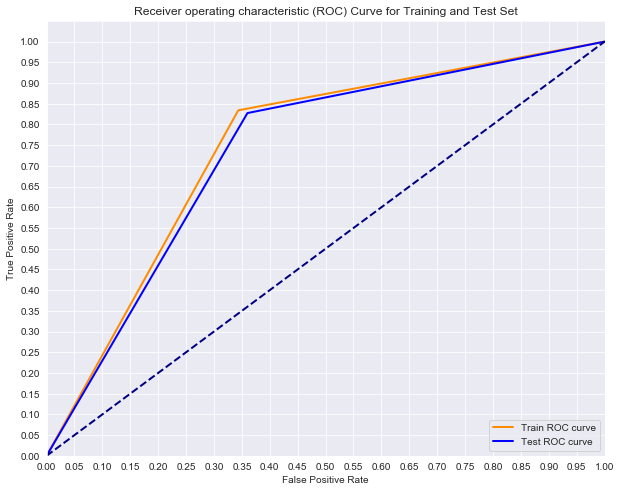

Training AUC: 0.74532
Test AUC: 0.73376



Confusion Matrix
TP | FN
FP | TN
[[832 468]
 [ 79 379]]



Classification Report
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1300
           1       0.45      0.83      0.58       458

    accuracy                           0.69      1758
   macro avg       0.68      0.73      0.67      1758
weighted avg       0.79      0.69      0.71      1758




Training Recall:  0.8342
Testing Recall:  0.8275



Training F_Beta Score 0.7223
Testing F_Beta Score 0.7074
Training Cohen's Kappa 0.3938
Testing Cohen's Kappa 0.3667



Training Precision:  0.47
Testing Precision:  0.4475



Training Accuracy:  0.704
Testing Accuracy:  0.6889



Training F1-Score:  0.6013
Testing F1-Score:  0.5808





In [117]:
quick_model_eval(X_train, X_test, y_train, y_test, svm_clf)

<b>Model results were completely unchanged after GridSearch. SVM machine seems less reliable when it comes to predicting True Positives and predicts more False Negatives

In [118]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [120]:
results = [10, 'SVM After GridSearch', 74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6, 'No Change',1.2]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [121]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes,Train_Test_Difference
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...,3.0
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed",0.5
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...,1.2
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m...",1.2
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting,31.7
0,6,Random Forest Classifier after GridSearch,80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7,Overfitting After GridSearch,6.4
0,7,RFC after Feature Selection,80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6,Overfitting After Feature Selection,5.9
0,8,RFC after GridSearch w/ Max Features,77.9,75.3,81.1,79.2,72.0,79.0,73.7,70.7,48.2,42.5,,2.6
0,9,Vanilla Linear SVM,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,Highest Recall Score,1.2
0,10,SVM After GridSearch,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,No Change,1.2


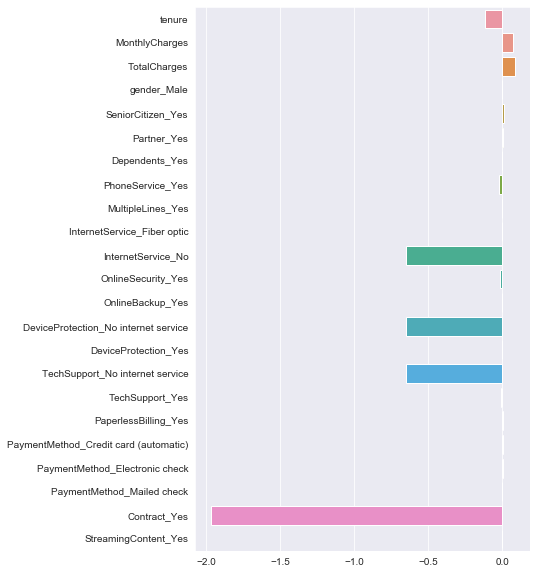

In [246]:
plt.figure(figsize=(6,10))
svm_clf_df=pd.DataFrame(svm_clf.coef_,columns = X_train.columns)
sns.barplot(data=svm_clf_df, orient='h')

# Gradient Boosting Classifier

<b>Random Forest Classifier was the best performing model overall so I will now attempt to use Gradient Boosting to boost the models predictive power

In [128]:
gbc_clf = GradientBoostingClassifier()
gbc_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

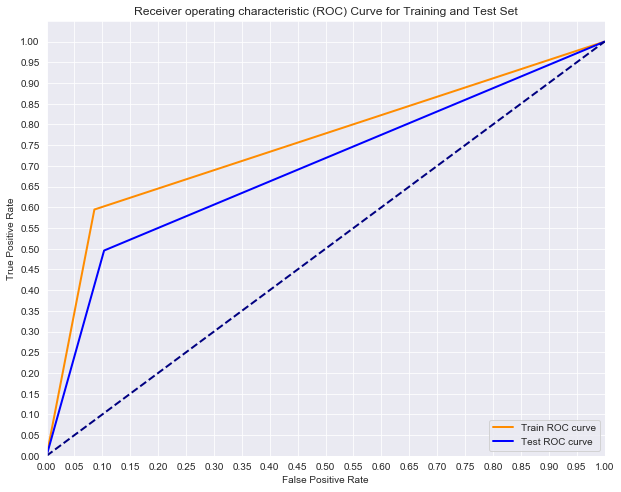

Training AUC: 0.75446
Test AUC: 0.69628



Confusion Matrix
TP | FN
FP | TN
[[1166  134]
 [ 231  227]]



Classification Report
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1300
           1       0.63      0.50      0.55       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758




Training Recall:  0.5946
Testing Recall:  0.4956



Training F_Beta Score 0.6156
Testing F_Beta Score 0.5176
Training Cohen's Kappa 0.5381
Testing Cohen's Kappa 0.4215



Training Precision:  0.7171
Testing Precision:  0.6288



Training Accuracy:  0.8288
Testing Accuracy:  0.7924



Training F1-Score:  0.6501
Testing F1-Score:  0.5543





In [129]:
quick_model_eval(X_train,X_test,y_train,y_test,model=gbc_clf)

<b> Initial model overfit and not very predictive. Predicts churn 1s at the same rate as a random coin flip. Will tune using SMOTE data next to see if that enhances the predicting of Churn 1's

In [162]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [163]:
results = [11, 'Vanilla Gradient Booster', 75.4,69.6,59.4,49.5,90.0,50.0,61.5,51.7,53.8,42.1, 'Overfitting',4.8]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [164]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes,Train_Test_Difference
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...,3.0
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed",0.5
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...,1.2
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m...",1.2
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting,31.7
0,6,Random Forest Classifier after GridSearch,80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7,Overfitting After GridSearch,6.4
0,7,RFC after Feature Selection,80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6,Overfitting After Feature Selection,5.9
0,8,RFC after GridSearch w/ Max Features,77.9,75.3,81.1,79.2,72.0,79.0,73.7,70.7,48.2,42.5,,2.6
0,9,Vanilla Linear SVM,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,Highest Recall Score,1.2
0,10,SVM After GridSearch,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,No Change,1.2


<b> Ran model with SMOTE data

In [130]:
gbc_clf = GradientBoostingClassifier()
gbc_clf.fit(X_train_SMOTE, y_train_SMOTE)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

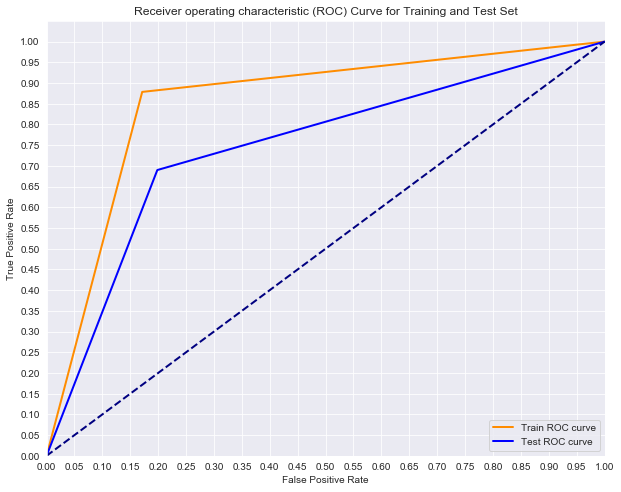

Training AUC: 0.85361
Test AUC: 0.74575



Confusion Matrix
TP | FN
FP | TN
[[1042  258]
 [ 142  316]]



Classification Report
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1300
           1       0.55      0.69      0.61       458

    accuracy                           0.77      1758
   macro avg       0.72      0.75      0.73      1758
weighted avg       0.79      0.77      0.78      1758




Training Recall:  0.8786
Testing Recall:  0.69



Training F_Beta Score 0.8699
Testing F_Beta Score 0.6567
Training Cohen's Kappa 0.7072
Testing Cohen's Kappa 0.4542



Training Precision:  0.8368
Testing Precision:  0.5505



Training Accuracy:  0.8536
Testing Accuracy:  0.7725



Training F1-Score:  0.8572
Testing F1-Score:  0.6124





In [132]:
quick_model_eval(X_train_SMOTE,X_test,y_train_SMOTE,y_test,model=gbc_clf)

<b> Overfitting was worse. Moving on to feature selection

In [165]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [179]:
results = [12, 'Gradient Booster SMOTE', 85.4,74.5,87.8,69.0,80.0,69.0,86.9,65.6,70.7,45.4, 'Overfitting Worse',10.8]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [180]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes,Train_Test_Difference
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...,3.0
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed",0.5
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...,1.2
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m...",1.2
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting,31.7
0,6,Random Forest Classifier after GridSearch,80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7,Overfitting After GridSearch,6.4
0,7,RFC after Feature Selection,80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6,Overfitting After Feature Selection,5.9
0,8,RFC after GridSearch w/ Max Features,77.9,75.3,81.1,79.2,72.0,79.0,73.7,70.7,48.2,42.5,,2.6
0,9,Vanilla Linear SVM,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,Highest Recall Score,1.2
0,10,SVM After GridSearch,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,No Change,1.2


<b>Plotted coefficients on Gradient Boosted Model and removed those with less predictive power

ValueError: shape mismatch: objects cannot be broadcast to a single shape

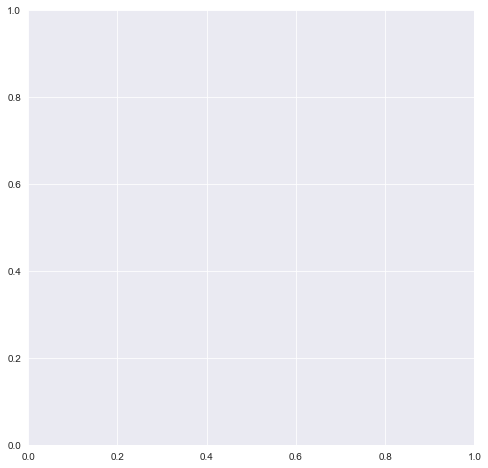

In [181]:
plot_feature_importance(gbc_clf)

In [182]:
X_gbc_feature_selects = X_feature_selected[['StreamingContent_Yes','Contract_Yes','PaymentMethod_Electronic check',
                                           'PaperlessBilling_Yes','TechSupport_Yes','OnlineSecurity_Yes',
                                           'InternetService_Fiber optic','MultipleLines_Yes','Dependents_Yes','MonthlyCharges',
                                           'tenure']]
X_gbc_feature_selects

,StreamingContent_Yes,Contract_Yes,PaymentMethod_Electronic check,PaperlessBilling_Yes,TechSupport_Yes,OnlineSecurity_Yes,InternetService_Fiber optic,MultipleLines_Yes,Dependents_Yes,MonthlyCharges,tenure
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.115423,0.000000
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.385075,0.464789
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.354229,0.014085
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.239303,0.619718
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.521891,0.014085
...,...,...,...,...,...,...,...,...,...,...,...
7027,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.662189,0.323944
7028,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.845274,1.000000
7029,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.112935,0.140845
7030,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.558706,0.042254


In [183]:
X_train_gbc, X_test_gbc, y_train_gbc, y_test_gbc = train_test_split(X_gbc_feature_selects,y,test_size = 0.25, random_state=42)

In [184]:
gbc_clf = GradientBoostingClassifier()
gbc_clf.fit(X_train_gbc, y_train_gbc)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

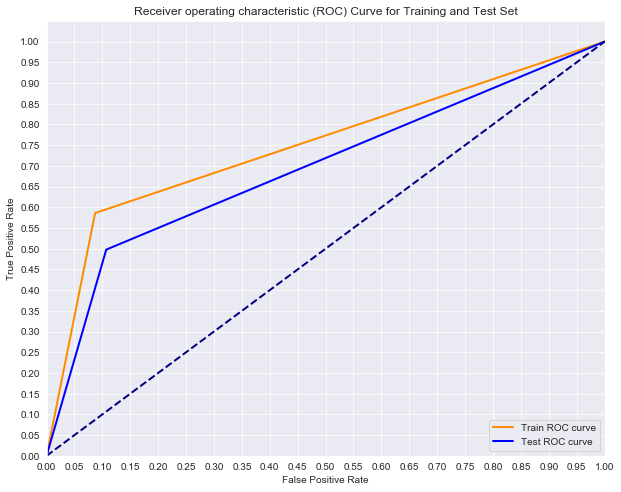

Training AUC: 0.74957
Test AUC: 0.69545



Confusion Matrix
True 0s | False 1s
False 0s | True 1s
[[1161  139]
 [ 230  228]]



Classification Report
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1300
           1       0.62      0.50      0.55       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758




Training Recall:  0.5861
Testing Recall:  0.4978



Training F_Beta Score 0.6075
Testing F_Beta Score 0.5184
Training Cohen's Kappa 0.5286
Testing Cohen's Kappa 0.4178



Training Precision:  0.7111
Testing Precision:  0.6213



Training Accuracy:  0.8256
Testing Accuracy:  0.7901



Training F1-Score:  0.6426
Testing F1-Score:  0.5527





In [185]:
quick_model_eval(X_train_gbc,X_test_gbc,y_train_gbc,y_test_gbc,model=gbc_clf)

<b> Overfitting got better but it lost its predictive power. Moving on to gridsearch

In [186]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [187]:
results = [13, 'GB Feature Select', 74.9,69.5,58.6,49.8,89.0,50.0,60.7,51.8,52.8,41.7, 'Lost Predictive Power',5.4]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

<b> Ran GridSearch and input new hyperparameter values into new model

In [142]:
gbc_clf = GradientBoostingClassifier()
param_grid = {
     'n_estimators':[100,150,200,250,300],
    'learning_rate':[1,0.1,0.01,0.001,0.0001],
    'min_samples_split':[2,3,5,7,9],
    'min_samples_leaf':[2,3,5,7,9],
    'max_depth':[1,3,5,7,9],
    'max_features':[1,3,5,7,9]

}
gbc_clf = GridSearchCV(gbc_clf, param_grid, cv=3, n_jobs=-1)
gbc_clf.fit(X_train_gbc, y_train_gbc)

{'C': 1000, 'gamma': 1}

In [143]:
gbc_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 250}

In [144]:
gbc_clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, max_features=1,min_samples_leaf=7, min_samples_split=2, n_estimators=250)
gbc_clf.fit(X_train_gbc, y_train_gbc)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=1, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

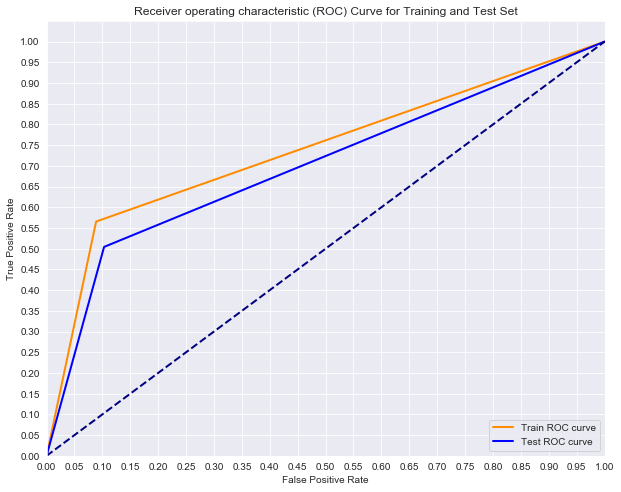

Training AUC: 0.73838
Test AUC: 0.70064



Confusion Matrix
TP | FN
FP | TN
[[1166  134]
 [ 227  231]]



Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1300
           1       0.63      0.50      0.56       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.79      1758




Training Recall:  0.5656
Testing Recall:  0.5044



Training F_Beta Score 0.5881
Testing F_Beta Score 0.5257
Training Cohen's Kappa 0.5076
Testing Cohen's Kappa 0.4295



Training Precision:  0.6994
Testing Precision:  0.6329



Training Accuracy:  0.8187
Testing Accuracy:  0.7947



Training F1-Score:  0.6254
Testing F1-Score:  0.5614





In [145]:
quick_model_eval(X_train_gbc,X_test_gbc,y_train_gbc,y_test_gbc,model=gbc_clf)

<b> Overfitting issues still present and predictive powers could be better. Will SMOTE new values based on feature selected dataframe and input those into the model

In [188]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [189]:
results = [14, 'GridSearch GB Model', 73.8,70.0,56.5,50.4,90.00,50.0,58.8,52.5,50.7,42.9, 'Overfit and Underpowered',3.8]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [146]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_gbc_SMOTE, y_train_gbc_SMOTE = smote.fit_sample(X_train_gbc, y_train_gbc) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_gbc_SMOTE).value_counts()) 

Original class distribution: 

0    5163
1    1869
Name: Churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
dtype: int64


In [147]:
gbc_clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, max_features=1,min_samples_leaf=7, min_samples_split=2, n_estimators=250)
gbc_clf.fit(X_train_gbc_SMOTE, y_train_gbc_SMOTE)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=1, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

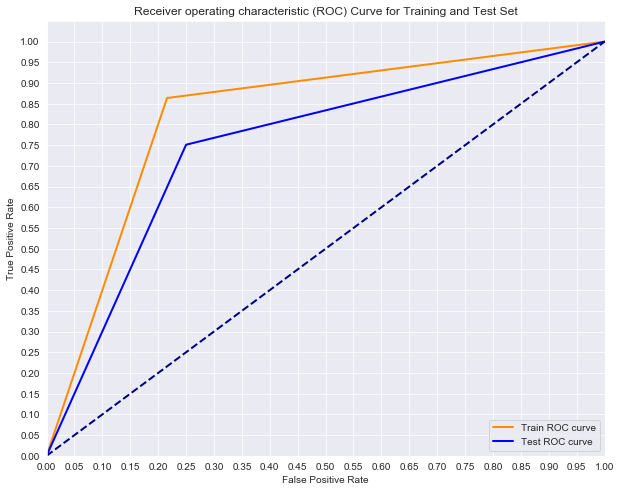

Training AUC: 0.82397
Test AUC: 0.75055



Confusion Matrix
TP | FN
FP | TN
[[975 325]
 [114 344]]



Classification Report
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1300
           1       0.51      0.75      0.61       458

    accuracy                           0.75      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.80      0.75      0.76      1758




Training Recall:  0.8638
Testing Recall:  0.7511



Training F_Beta Score 0.8503
Testing F_Beta Score 0.6877
Training Cohen's Kappa 0.6479
Testing Cohen's Kappa 0.436



Training Precision:  0.8
Testing Precision:  0.5142



Training Accuracy:  0.824
Testing Accuracy:  0.7503



Training F1-Score:  0.8307
Testing F1-Score:  0.6105





In [148]:
quick_model_eval(X_train_gbc_SMOTE,X_test_gbc,y_train_gbc_SMOTE,y_test_gbc,model=gbc_clf)

<b> SMOTE data made overfitting worse. Will GridSearch one last time with new SMOTE data in GridSearch

In [190]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [191]:
results = [15, 'GB SMOTE 2.0', 82.3,75.0,86.3,75.1,75.0,75.0,85.0,68.7,64.7,43.6, 'Overfitting Worse',7.3]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

<b> Last GridSearch and GB Model

In [150]:
gbc_clf = GradientBoostingClassifier()
param_grid = {
     'n_estimators':[100,150,200,250,300],
    'learning_rate':[1,0.1,0.01,0.001,0.0001],
    'min_samples_split':[2,3,5,7,9],
    'min_samples_leaf':[2,3,5,7,9],
    'max_depth':[1,3,5,7,9],
    'max_features':[1,3,5,7,9]

}
gbc_clf = GridSearchCV(gbc_clf, param_grid, cv=3, n_jobs=-1)
gbc_clf.fit(X_train_gbc_SMOTE, y_train_gbc_SMOTE)

gbc_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 9,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [160]:
gbc_clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 1, max_features=1,min_samples_leaf=2, min_samples_split=2, n_estimators=150)
gbc_clf.fit(X_train_gbc_SMOTE, y_train_gbc_SMOTE)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=1, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

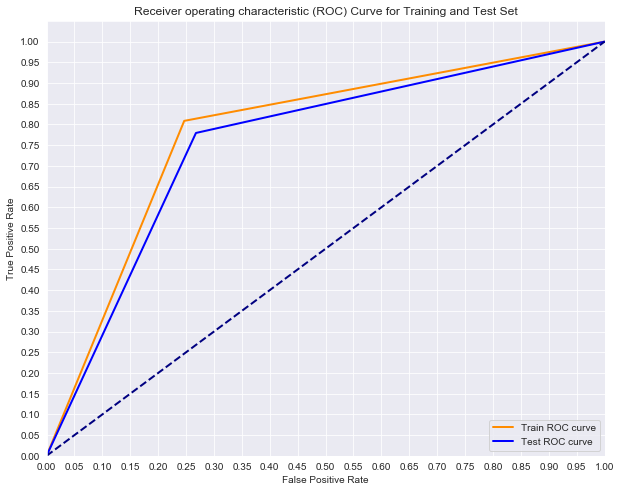

Training AUC: 0.781
Test AUC: 0.75589



Confusion Matrix
True 0s | False 1s
False 0s | True 1s
[[952 348]
 [101 357]]



Classification Report
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1300
           1       0.51      0.78      0.61       458

    accuracy                           0.74      1758
   macro avg       0.71      0.76      0.71      1758
weighted avg       0.80      0.74      0.76      1758




Training Recall:  0.8087
Testing Recall:  0.7795



Training F_Beta Score 0.7998
Testing F_Beta Score 0.7036
Training Cohen's Kappa 0.562
Testing Cohen's Kappa 0.4357



Training Precision:  0.7662
Testing Precision:  0.5064



Training Accuracy:  0.781
Testing Accuracy:  0.7446



Training F1-Score:  0.7869
Testing F1-Score:  0.6139





In [161]:
quick_model_eval(X_train_gbc_SMOTE,X_test_gbc,y_train_gbc_SMOTE,y_test_gbc,model=gbc_clf)

<b> Model no longer overfits

In [194]:
column_names

['Model #',
 'Model Type',
 'Train AUC',
 'Test AUC',
 'Train Recall',
 'Test Recall',
 'Recall 0',
 'Recall 1',
 'Train F_Beta Score',
 'Test F_Beta Score',
 'Train Cohens Kappa',
 'Test Cohens Kappa',
 'Notes',
 'Train_Test_Difference']

In [195]:
results = [16, 'GB SMOTE/GridSearch 2.0', 78.1,75.5,80.8,77.9,73.0,78.0,79.9,70.3,56.2,43.5, ' ',2.6]
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [197]:
model_results

,Model #,Model Type,Train AUC,Test AUC,Train Recall,Test Recall,Recall 0,Recall 1,Train F_Beta Score,Test F_Beta Score,Train Cohens Kappa,Test Cohens Kappa,Notes,Train_Test_Difference
0,1,Vanilla Log Reg,73.2,70.2,57.1,51.9,89.0,52.0,58.7,53.6,48.6,42.7,Baseline performs poorly when attempting to pr...,3.0
0,2,SMOTE Log Reg,76.7,76.2,77.4,77.0,75.0,77.0,77.4,77.0,47.0,45.5,"Model performed better, additional tuning needed",0.5
0,3,Class Weight Balanced Log Reg,77.0,75.8,79.1,77.9,74.0,78.0,72.2,70.5,47.0,44.2,Balanced class weights results in slightly bet...,1.2
0,4,CWB Log Reg w/ Feature Selection,76.3,75.1,77.7,75.7,75.0,76.0,71.1,69.1,46.0,43.5,"Slightly worse model, moving on to different m...",1.2
0,5,Vanilla Random Forest,99.7,68.0,99.5,46.7,89.0,47.0,99.5,48.9,99.5,39.0,Significant Overfitting,31.7
0,6,Random Forest Classifier after GridSearch,80.9,74.5,82.9,74.4,75.0,74.0,76.7,68.1,54.8,42.7,Overfitting After GridSearch,6.4
0,7,RFC after Feature Selection,80.3,74.4,81.8,74.0,75.0,74.0,75.8,67.8,58.5,42.6,Overfitting After Feature Selection,5.9
0,8,RFC after GridSearch w/ Max Features,77.9,75.3,81.1,79.2,72.0,79.0,73.7,70.7,48.2,42.5,,2.6
0,9,Vanilla Linear SVM,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,Highest Recall Score,1.2
0,10,SVM After GridSearch,74.5,73.3,83.4,82.7,64.0,83.0,72.2,70.7,39.3,36.6,No Change,1.2


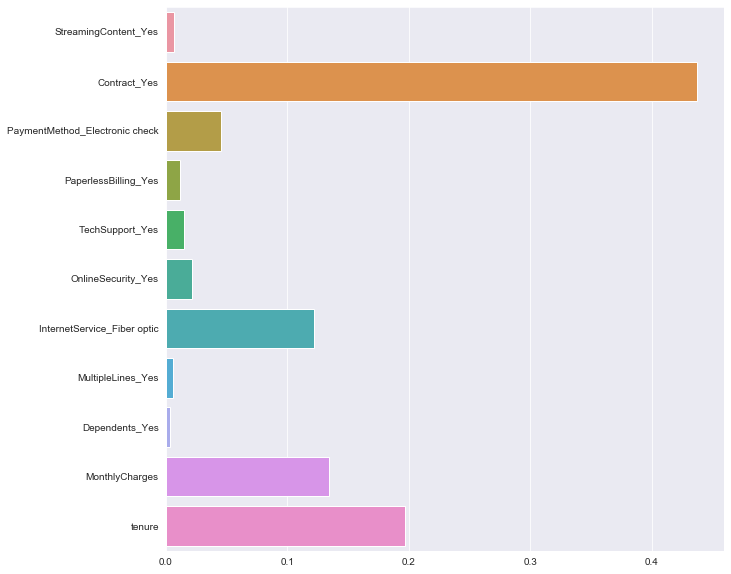

In [256]:
gbc_df=pd.DataFrame(gbc_clf.feature_importances_, index = list(X_gbc_feature_selects.columns)).transpose()
plt.figure(figsize=(10,10))
sns.barplot(data=gbc_df, orient='h')

<b>Most important coefficients are contract, tenure, monthly charges, and Internet Service Fiber Optic

# Conclusion
<b> Across all models the most predictive variables are whether the customer has a contract, how long they have been with the service (tenure), and Internet Service Fiber Optic plans